In [12]:
import numpy as np
import json
import matplotlib.pyplot as plt

In [149]:
with open('wp-5-00.json') as f:
    group = json.load(f)
e = np.array(group['members'][0]).reshape(3,3)
#e = np.array([0, 0, 0.2, 0.1, 1, 0, 0, 0, 1]).reshape(3,3)
basis = np.array(group['projector']).reshape(4,4) @ np.array([50,0,0,50])
basis = basis.reshape(2,2)
ib = np.linalg.inv(basis)
print(e)
print(ib)
print(basis)
print(ib @ basis)

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.02 0.  ]
 [0.   0.02]]
[[50.  0.]
 [ 0. 50.]]
[[1. 0.]
 [0. 1.]]


In [150]:
def scale(x, ib=ib):
    s = x @ ib
    return np.fmod(s, 1.0)
def unscale(x, basis=basis):
    return x @ basis
x = np.array([0.5,0.5])
print(x)
print(unscale(x))
print(scale(unscale(x)))

[0.5 0.5]
[25. 25.]
[0.5 0.5]


In [151]:
def pa(x, e=e):
    return (e @ (np.concatenate((x, [1])).T))[:2]
pa(x)

array([0. , 0.5])

In [152]:
# compute A matrix
N = 2
A = np.zeros((N, N))
grad = [0,0,0]
for k in range(N):
    for l in range(N):
        b = 0
        c = 0
        d = 0
        for j in range(N):
            a = 0
            for i in range(N):
                a += ib[j,i]
            c += e[k,j] * a
            d += e[l,j] * a
        a = 0
        b = 0
        for i in range(N):
            a += ib[k,i]
            b += ib[l,i]
        print(c,a,d,b)
        A[k,l] = (c - a) * (d - b)
    grad[k] = c - a
print(A)
Ainv = np.linalg.pinv(A)
print(Ainv @ A)
for i in range(N):
    Ainv[i, :] *= grad[i]
print(Ainv)

0.0 0.02 0.0 0.02
0.0 0.02 0.02 0.02
0.02 0.02 0.0 0.02
0.02 0.02 0.02 0.02
[[ 0.0004 -0.    ]
 [-0.      0.    ]]
[[1. 0.]
 [0. 0.]]
[[-50.  -0.]
 [  0.   0.]]


In [148]:
def step(x, v, f, dt, gamma=0.05, T = 0.2):
    # b
    v += f(x) * dt / 2
    # a 
    x += v * dt / 2
    # constraint 1
    s = scale(x)
    delta = pa(s) - s
    l = Ainv @ delta.T
    v -= l / dt / 2
    x -= l
    s = scale(x)
    delta = pa(s) - s
    # o
    c1 = np.exp(-gamma * dt)
    c2 = np.sqrt(1 - c1**2)
    v *= c1
    v += c2 * np.random.normal() * np.sqrt(T)
    # a 
    x += dt * v / 2    
    # constraint 2
    s = scale(x)
    delta = pa(s) - s
    l = Ainv @ delta.T
    v -= l / dt / 2
    x -= l
    s = scale(x)
    delta = pa(s) - s
    # b
    v += f(x) * dt / 2
    return x,v
x = np.array([0.5,0.5], dtype=float)
x = unscale(pa(x))
f = lambda x: -2 * np.sqrt(np.sum(x**2)) * x
v = np.array([0.5, 1], dtype=float)
N = 10
traj = np.empty((N, 2), dtype=float)
vtraj = np.empty((N, 2), dtype=float)
for i in range(N):
    traj[i,:] = x
    vtraj[i,:] = v
    x,v = step(x, v, f, 0.05)    
    print(x)

[ 9.89809723 25.54669014]
[ 9.89427284 20.11927856]
[ 9.89306553 12.46688601]
[9.8935772  3.85070893]
[ 9.89486456 -4.94381968]
[  9.89551018 -13.43662339]
[  9.894807   -20.77994942]
[  9.89325276 -25.70474641]
[  9.89151422 -27.06840285]
[  9.89031543 -24.52053334]


(-0.28619213493057644,
 10.410034833542104,
 0.08685767782370787,
 0.7441833211250056)

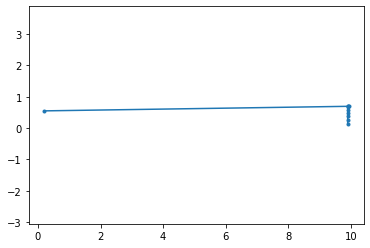

In [146]:
plt.plot(traj[:,0], traj[:,1], '.-')
# for i in range(N):
#     xi = traj[i]
#     vi = vtraj[i]
#     vi /= np.linalg.norm(vi) / 0.2
#     plt.plot([xi[0], xi[0] + vi[0]], [xi[1], xi[1] + vi[1]], '-', color='C1')
plt.gca().axis('equal')